In [1]:
# External libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import requests

# helpful check routine
def is_downloadable(url):
    """
    Does the url contain a downloadable resource
    """
    h = requests.head(url, allow_redirects=True)
    header = h.headers
    content_type = header.get('content-type')
    if 'text' in content_type.lower():
        return False
    if 'html' in content_type.lower():
        return False
    return True

In [2]:
# CSI routines
import csi.planarfault as pf
import csi.gps as gr
import csi.insar as insar
import csi.geodeticplot as geoplt
import csi.seismiclocations as sl
import csi.imagedownsampling as down
import csi.fault3D as flt3D
import csi.faultwithvaryingdip as flt
import csi.verticalfault as verticalfault
#import csi.cosicorrrates as cr
import csi.imagecovariance as imcov


In [3]:
# set some flags
input_check = True
do_downsample = False
output_check = False

CSI does most computations in a local Cartesian coordinate system. It presently supports only UTM projections, so we need to set the zone to use.

In [4]:
# UTM zone 11 for eastern California
utmzone = 11

For this example, we will use an InSAR dataset for the 2019 Ridgecrest earthquake, published online at the Harvard Dataverse:

Fielding, Eric Jameson, 2019, "Replication Data for: Surface deformation related to the 2019 Mw 7.1 and Mw 6.4 Ridgecrest Earthquakes in California from GPS, SAR interferometry, and SAR pixel offsets", https://doi.org/10.7910/DVN/JL9YMS, Harvard Dataverse, V2

The dataset we will start with is the ALOS-2 interferogram from ascending track 65. We set the output name for the dataset.

In [5]:
# set the output name root
outName = 'A2A065'  # ALOS-2 Ascending track 65

We use the masked range-change file to avoid using data from areas with low coherence that is less reliable. We can use the `requests` library to download the file to the local directory from Python (or you could click on the links at the main URL above which is faster). The code below will download the file if it does not already exist in the directory.

In [6]:
# range-change file name locally
a65_rng='ALOS2_A065_20180416-20190708_masked_range_change_m.grd'
if os.path.exists(a65_rng) == False:   # if the file not here yet
    # store direct download url of range-change dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/PUWBZX'
    if is_downloadable(url): # does URL point to a file?
        # Download data into a requests variable with the above url
        r = requests.get(url, allow_redirects=True)
        # Write the content of above request variable to the file name
        open(a65_rng, 'wb').write(r.content)


We also need the three components of the line-of-sight (LOS) vector: East, North, and Up.

In [7]:
# East file name locally
a65_east='ALOS2_A065_20180416-20190708_east_1asec.grd'
if os.path.exists(a65_east) == False:   # if the file not here yet
    # store direct download url of East dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/CFBGNV'
    # Download data into a requests variable with the above url
    r = requests.get(url, allow_redirects=True)
    # We are writing the content of above request to the file name
    open(a65_east, 'wb').write(r.content)

# North file name locally
a65_north='ALOS2_A065_20180416-20190708_north_1asec.grd'
if os.path.exists(a65_north) == False:   # if the file not here yet
    # url of North dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/PBIERE'
    # Download data into a requests variable with the above url
    r = requests.get(url, allow_redirects=True)
    # Write the content of above request variable to the file name
    open(a65_north, 'wb').write(r.content)

# Up file name locally
a65_up='ALOS2_A065_20180416-20190708_up_1asec.grd'
if os.path.exists(a65_north) == False:   # if the file not here yet
    # url of North dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/YDEEMX'
    # Download data into a requests variable with the above url
    r = requests.get(url, allow_redirects=True)
    # Write the content of above request variable to the file name
    open(a65_up, 'wb').write(r.content)


Now we are ready to create a CSI InSAR object with this dataset.

In [9]:
# Instantiate a insar object
sar = insar('A2_A065_coseismic', utmzone=utmzone)
print ('reading from GMT grd files',a65_rng) # print is a little redundant
sar.read_from_grd( a65_rng, los=[a65_east, a65_north, a65_up])


---------------------------------
---------------------------------
Initialize InSAR data set A2_A065_coseismic
reading from GMT grd files ALOS2_A065_20180416-20190708_masked_range_change_m.grd
Read from file ALOS2_A065_20180416-20190708_masked_range_change_m.grd into data set A2_A065_coseismic


Check the dataset for NaN (no data in GMT) pixels and remove them.

In [10]:
# clean out NaNs if present
sar.checkNaNs()


We can use the `plot` method of the InSAR class to plot the dataset and check that it was read correctly. The `input_check` flag above controls whether this is done. This step can take a while for large images. The `norm` parameter controls the color scale.

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


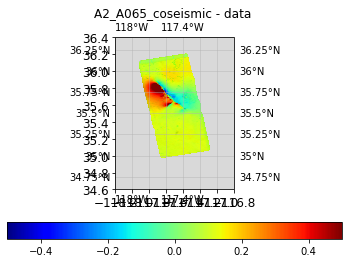

In [11]:
# check data read in if flag set
if input_check:
    sar.plot(faults=None,figure=127,norm=[-0.5,0.5])

Now we can estimate the covariance of the dataset using the semivariogram method. First we create a image covariance object from the InSAR object.

In [12]:
# Covariance first estimate on original data
covar = imcov('Covariance estimator',sar, verbose=True)

---------------------------------
---------------------------------
Initialize InSAR covariance tools Covariance estimator


We will mask out the area close to the main rupture to look at the rest of the scene.

In [13]:
# mask out high deformation above earthquake rupture
covar.maskOut([[-118.0, -117.25, 35.55, 35.95]])

Masking data set Covariance estimator
     Mask: -118.0 <= Lon <= -117.25 || 35.55 <= Lat <= 35.95


We use the `computeCovariance` method to sample the dataset with a random set on 0.002 of the pixels, estimate and remove a ramp, calculate the semivariogram at distances of every 2 km out to 100 km, convert the semivariogram to covariance, and estimate a fit of an exponential function vs. distance.

In [14]:
covar.computeCovariance(function='exp', frac=0.002, every=2.0, distmax=100., rampEst=True)

Computing covariograms
Computing 1-D empirical semivariogram function for data set Covariance estimator
Selecting 16028 random samples to estimate the covariance function
Estimated Orbital Plane: -3.4665518852367864e-05xy + 0.13375223760488297x + 0.01550056454564969y + -59.674849380877234
Build the permutations
Digitize the histogram
Fitting Covariance functions
Dataset Covariance estimator:
A prior values: Sill | Sigma | Lambda
                 0.000850 | 0.004217 | 39.788291
Dataset Covariance estimator:
     Sill   :  0.00039557243022636426
     Sigma  :  0.07061470016722794
     Lambda :  39.78829171795961


Now we can plot the results with the `plot` method.

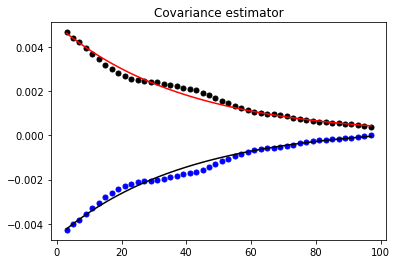

In [15]:
covar.plot(data='all')

Save the exponential fit to a file with the default output name `Covariance_estimator.cov` for use in estimating the data covariance of downsampled data.

In [16]:
covar.write2file(savedir='./')

writing covariance output for Covariance estimator
